In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from random import *
from math import log
import copy
pd.set_option('display.max_columns', None)
from pandas.io.json import json_normalize

from scipy.stats.stats import pearsonr   
%matplotlib inline

In [2]:
# load business and user data
with open('dataset/business.json') as f:
    business_data = [json.loads(line) for line in f]
with open('dataset/user.json') as f:
    user_data = [json.loads(line) for line in f]  

In [3]:
# preprocessed file with reviews only for restaurants
with open('dataset/restaurant_reviews.json', encoding = 'utf-8') as f:
    review_data = [json.loads(line) for line in f]

In [4]:
# convert array to list (how preprocessed file was formatted)
restaurant_reviews = review_data[0]

In [5]:
# pull just restaurant data from business data
restaurant_data = [x for x in business_data if 'Restaurants' in x['categories']]

In [6]:
del review_data
del business_data

In [7]:
# pandas dataframe of restaurant data
restaurant_df = json_normalize(restaurant_data)

In [8]:
# take 100000 reviews as sample
data_array = (np.random.choice(restaurant_reviews, size = 100000))
data_set = list(data_array)

In [9]:
# find all categories for one-hot encoding purposes
from collections import Counter
all_categories = []
for r in restaurant_data:
    if 'Restaurants' in r['categories']:
        for c in r['categories']:
            all_categories.append(c)

In [10]:
# take 150 most popular categories
counts = list (Counter(all_categories).items())
counts.sort(key=lambda x: x[1], reverse = True)
most_popular = [x[0] for x in counts[:150]]

In [11]:
# create restaurant and user dictionaries for easy lookup
restaurant_dict = {}
for item in restaurant_data:
    restaurant_id = item['business_id']
    restaurant_dict[restaurant_id] = item

user_dict = {}
for item in user_data:
    user_id = item['user_id']
    user_dict[user_id] = item

In [12]:
# make copy of the reviews array
expanded_reviews = copy.deepcopy(data_array)

In [13]:
# add business and user info
for review in expanded_reviews:
    #print (review)
    restaurant = review['business_id']
    user = review['user_id']
    restaurant_info = restaurant_dict[restaurant]
    #print (restaurant_info)
    user_info = user_dict[user]
    for attribute in restaurant_info:
        #print (attribute)
        if attribute not in ['is_open', 'latitude','longitude','name','business_id',
                             'neighborhood','address','city','postal_code','hours']:
            if attribute == 'categories':
                for c in most_popular:
                    if c in restaurant_info[attribute]:
                        review['R_' +  c] = 1
                    else:
                        review['R_' +  c] = 0
            else:         
                review['R_' + attribute] = restaurant_info[attribute]
    for attribute in user_info:
        if attribute not in ['user_id','name']:   
            if attribute == 'friends':
                review['U_friends'] = len(user_info[attribute])
            elif attribute == 'yelping_since':
                review['U_yelping_since'] = user_info[attribute][:4]
            elif attribute == 'elite':
                if user_info[attribute]:
                    review['U_elite'] = True
                else:
                    review['U_elite'] = False        
            else:
                review['U_' + attribute] = user_info[attribute] 

In [14]:
# create pandas dataframe
flatframe = json_normalize(expanded_reviews)
flatframe = flatframe.drop(['text','useful','funny','cool','date'], axis=1)

In [15]:
# change user since
flatframe['U_years_yelping'] = [2015 - int(x) for x in flatframe['U_yelping_since']]
flatframe.drop(['U_yelping_since'],axis = 1, inplace = True)

In [16]:
# drop ids
flatframe_wids = flatframe.drop(['business_id', 'review_id', 'user_id'], axis = 1)

In [17]:
#one hot encode
flatframe_wids = pd.get_dummies(flatframe_wids, columns = ['R_state', 
                                                    'R_attributes.Alcohol', 'R_attributes.AgesAllowed', 'R_attributes.RestaurantsAttire',
                                                    'R_attributes.RestaurantsPriceRange2','R_attributes.Smoking',
                                                    'R_attributes.WiFi', 'R_attributes.NoiseLevel','R_attributes.BYOBCorkage'])

In [18]:
# drop column if more than half of a column is nan
nan_count = {}
for column in flatframe_wids:
     nan_count[column] = flatframe_wids[column].isnull().sum()

nan_sorted = sorted(nan_count.items(), key=lambda x: x[1], reverse = True) 
drop_nans = [x[0] for x in nan_sorted if x[1] > 50000]

In [19]:
# drop some nans and fill some nans
flatframe_wids = flatframe_wids.drop(drop_nans, axis = 1)
flatframe_wids = flatframe_wids.fillna(flatframe_wids.mean())

In [20]:
# train test split
msk = np.random.rand(len(flatframe_wids)) < 0.5
data_train = flatframe_wids[msk]
data_test = flatframe_wids[~msk]

In [21]:
# make pandas dataframe for user data
user_df = json_normalize(user_data)

In [22]:
# train test split including business ids and user ids
data_train_temp = flatframe[msk]
data_test_temp = flatframe[~msk]

In [23]:
# global user average
users = data_train_temp.user_id.unique()
user_total = user_df[user_df['user_id'].isin(users)]['average_stars']
global_user_average = sum(user_total)/len(user_total)

In [24]:
# global restaurant average
restaurants = data_train_temp.business_id.unique()
restaurant_total = restaurant_df[restaurant_df['business_id'].isin(restaurants)]['stars']
global_restaurant_average = sum(restaurant_total)/len(restaurant_total)

In [25]:
# global review average
global_review_average = data_train['stars'].mean()

In [26]:
# user biases
user_deviations = {}
for item in user_data:
    user_id = item['user_id']
    user_deviations[user_id] = item['average_stars'] - global_user_average

In [27]:
# restaurant biases
restaurant_deviations = {}
for item in restaurant_data:
    rest_id = item['business_id']
    restaurant_deviations[rest_id] = item['stars'] - global_restaurant_average

In [28]:
# creating xy variables
Xtrain = data_train.drop(['stars'], axis = 1)
ytrain = data_train['stars']
Xtest = data_test.drop(['stars'], axis = 1)
ytest = data_test['stars']

In [29]:
def baseline(user_id, business_id):
    pred = global_review_average + user_deviations[user_id] + restaurant_deviations[business_id]
    return int(round(pred))

In [30]:
# predictions
base_pred = [baseline(x,y) for x,y in zip(data_train_temp['user_id'],data_train_temp['business_id'])]
base_pred_test = [baseline(x,y) for x,y in zip(data_test_temp['user_id'],data_test_temp['business_id'])]

In [31]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : base_pred})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : base_pred_test})

base_pred_avg = []
base_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    base_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    base_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

In [32]:
model = LinearRegression()
model.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
ypred = model.predict(Xtrain)
ypred_test = model.predict(Xtest)
predround = [int(round(x)) for x in ypred]

In [34]:
model_lasso = LassoCV().fit(Xtrain, ytrain)

In [35]:
lasso_ypred = model_lasso.predict(Xtrain)
lasso_ypred_round = [int(round(x)) for x in lasso_ypred]
lasso_ypred_test = model_lasso.predict(Xtest)
lasso_ypred_test_round = [int(round(x)) for x in lasso_ypred_test]

In [36]:
model_ridge = RidgeCV().fit(Xtrain, ytrain)

In [37]:
ridge_ypred = model_ridge.predict(Xtrain)
ridge_ypred_round = [int(round(x)) for x in ridge_ypred]
ridge_ypred_test = model_ridge.predict(Xtest)
ridge_ypred_test_round = [int(round(x)) for x in ridge_ypred_test]

In [38]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
knn.fit(Xtrain, ytrain)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')

In [39]:
ypred_train = np.round(knn.predict(Xtrain)).astype(int)
ypred_test = np.round(knn.predict(Xtest)).astype(int)

In [40]:
knn = KNeighborsRegressor(n_neighbors=1, n_jobs=-1)
knn.fit(Xtrain, ytrain)
ypred_train = np.round(knn.predict(Xtrain)).astype(int)
ypred_test = np.round(knn.predict(Xtest)).astype(int)
print ("The accuracy score of the knn model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, ypred_train)))
print ("The accuracy score of the knn model on the test set is {}"
       .format(metrics.accuracy_score(ytest, ypred_test)))

The accuracy score of the knn model on the train set is 0.9999601021385254
The accuracy score of the knn model on the test set is 0.3251724414501123


## Part 5: Ensemble Method

For this section, we did not include our matrix factorization model. This is because for matrix factorization, we deleted many datapoints to reduce the sparsity of the input matrix, resulting in a dataset of around 5000 entries for the training set. In contrast, the original training set that we used had 50,000 entries. Because we wished to generalize our model for as many restaurant-user combinations as possible, we found it most appropriate to keep the matrix factorization model out of the ensemble method.

### Majority Vote Model

In [41]:
from collections import Counter
predictions_train = []
predictions_test = []
counter_predictions_train = []
counter_predictions_test = []

# all the predictions in one place
base_pred = [baseline(x,y) for x,y in zip(data_train_temp['user_id'],data_train_temp['business_id'])]
base_pred_test = [baseline(x,y) for x,y in zip(data_test_temp['user_id'],data_test_temp['business_id'])]
ridge_ypred_round = [int(round(x)) for x in ridge_ypred]
ridge_ypred_test_round = [int(round(x)) for x in ridge_ypred_test]
#matrix factorization train
#matrix factorization test
knn_pred_train = np.round(knn.predict(Xtrain)).astype(int)
knn_pred_test = np.round(knn.predict(Xtest)).astype(int)

for i in range(len(ytrain)):
    temp = []
    temp.append(base_pred[i])
    temp.append(ridge_ypred_round[i])
    #temp.append(matrix factorization train)
    temp.append(knn_pred_train[i])
    counter_predictions_train.append(Counter(temp))
    predictions_train.append(temp)
    
for i in range(len(ytest)):
    temp = []
    temp.append(base_pred_test[i])
    temp.append(ridge_ypred_test_round[i])
    #temp.append(matrix factorization test)
    temp.append(knn_pred_test[i])
    counter_predictions_test.append(Counter(temp))
    predictions_test.append(temp)

In [42]:
# majority votes
ensemble_pred_train = []
ensemble_pred_test = []

for i in range(len(counter_predictions_train)):
    value, count = counter_predictions_train[i].most_common()[0]
    ensemble_pred_train.append(value)
    
for i in range(len(counter_predictions_test)):
    value, count = counter_predictions_test[i].most_common()[0]
    ensemble_pred_test.append(value)

In [43]:
print ("The accuracy score of the ensemble model (majority vote) on the train set is {}"
       .format(metrics.accuracy_score(ytrain, ensemble_pred_train)))
print ("The accuracy score of the ensemble model (majority vote) on the test set is {}"
       .format(metrics.accuracy_score(ytest, ensemble_pred_test)))

The accuracy score of the ensemble model (majority vote) on the train set is 0.47372725821895945
The accuracy score of the ensemble model (majority vote) on the test set is 0.40393407122232916


This ensemble method predicts by taking a majority vote of every model's prediction for a given predictor set. This improves upon all the models--both training and test accuracies are higher than any individual component model of the ensemble model (excluding training accuracy for kNN, which was 1 because k = 1).}

In [44]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : ensemble_pred_train})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : ensemble_pred_test})

majority_pred_avg = []
majority_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    majority_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    majority_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

(1, 5)

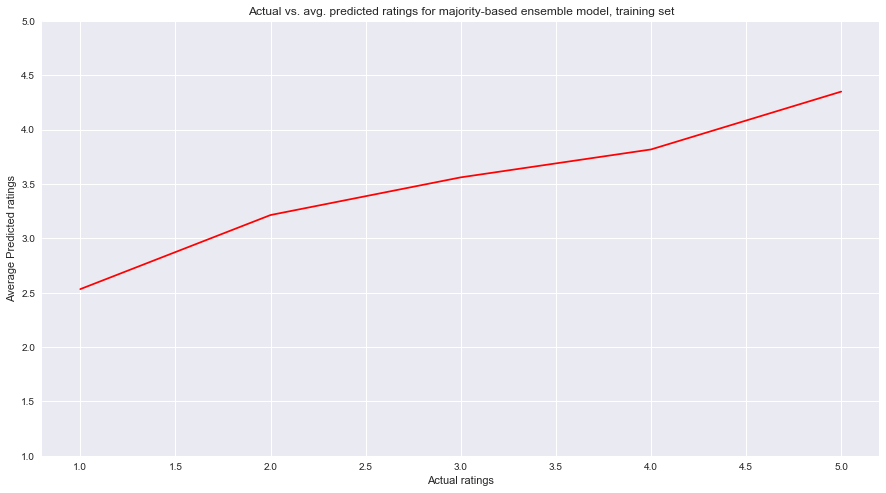

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], majority_pred_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for majority-based ensemble model, training set')
ax.set_ylim((1,5))

(1, 5)

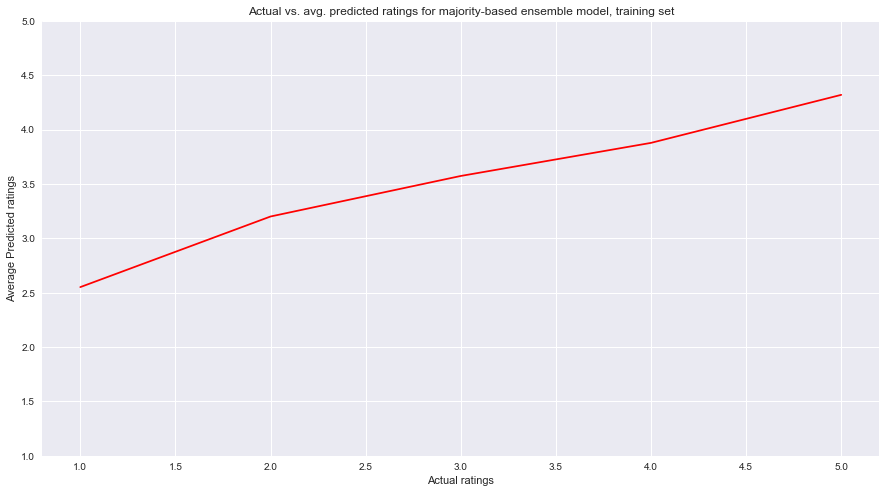

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], majority_pred_test_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for majority-based ensemble model, training set')
ax.set_ylim((1,5))

On average, our predictions for both the training and the test set follow the increasing trend of actual ratings but overestimate for lower ratings.

### Ensemble Method Using Logistic Regression

In [47]:
# logistic regression metaclassifier
logreg = LogisticRegressionCV()
y_hat_test = logreg.fit(predictions_train, ytrain).predict(predictions_test)
y_hat_train = logreg.fit(predictions_train, ytrain).predict(predictions_train)

print("Train LogReg: ", metrics.accuracy_score(ytrain, y_hat_train))
print("Test LogReg: ", metrics.accuracy_score(ytest, y_hat_test))

Train LogReg:  0.760453239706
Test LogReg:  0.357455085018


This model performed significantly better on the training set; however, it actually performed *worse* on the test set. This may be because of the kNN model being weighted more because of its high training accuracy due to its parameter k being 1.

In [48]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : y_hat_train})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : y_hat_test})

log_pred_avg = []
log_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    log_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    log_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

(1, 5)

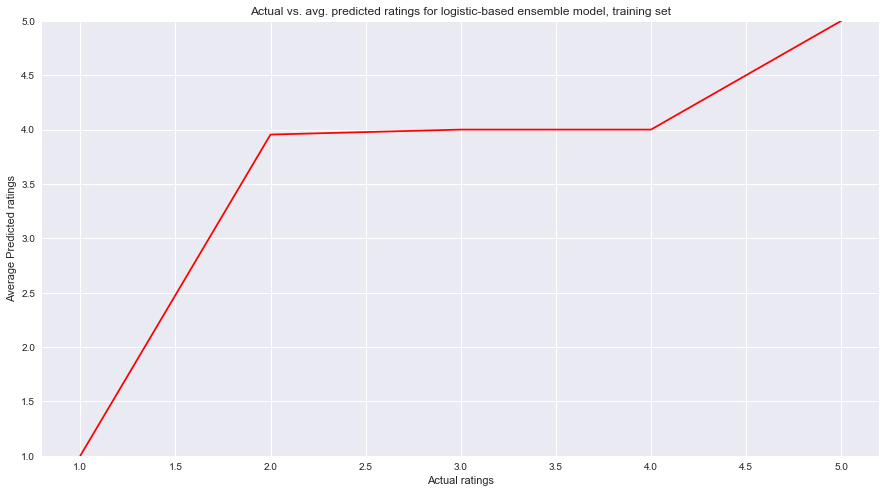

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], log_pred_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for logistic-based ensemble model, training set')
ax.set_ylim((1,5))

(1, 5)

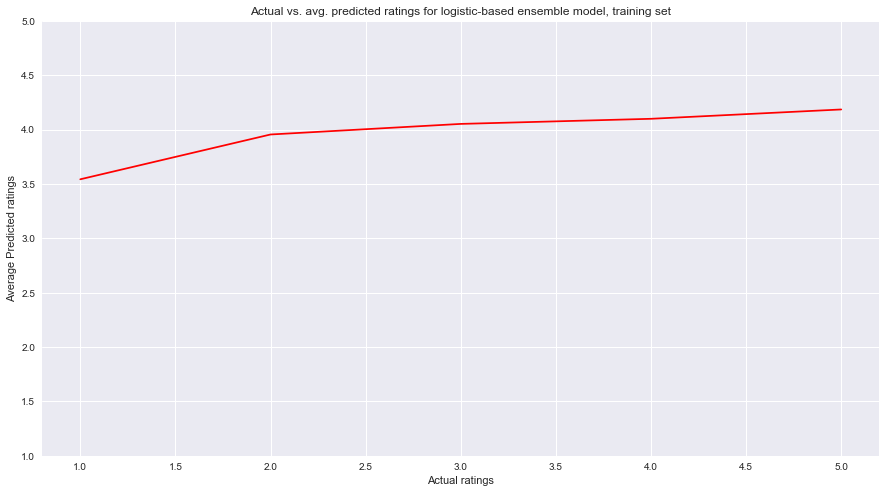

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], log_pred_test_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for logistic-based ensemble model, training set')
ax.set_ylim((1,5))

For the training set, the model performed well for when actual ratings were 1, 4, and 5 (not 2 and 3). The line was very flat for the test set, reflecting the large influence that the knn model had using this ensemble method.